# Feature Matching and Tracking

Feature matching
Optical flow
Object tracking
Multiple object tracking
Long-term tracking

Feature matching, optical flow, and object tracking are crucial techniques in computer vision for tasks such as object detection, motion estimation, and visual tracking. Here's an overview of each, along with relevant information and equations:

### Feature Matching:

Feature matching involves identifying and matching keypoints or distinctive features between images or frames. Keypoints can be corners, edges, or blobs that have unique characteristics. Common algorithms for feature matching include SIFT (Scale-Invariant Feature Transform), SURF (Speeded Up Robust Features), and ORB (Oriented FAST and Rotated BRIEF).

Equations:
- Matching keypoints involves finding correspondences between descriptors computed from keypoints in different images.
- One common method for matching is to use nearest neighbor search with distance metrics such as Euclidean distance or Hamming distance.
- Once matches are found, techniques like RANSAC (Random Sample Consensus) can be used to estimate geometric transformations like homography or affine transformation.

### Optical Flow:

Optical flow estimates the motion of objects between consecutive frames in a video sequence by analyzing the apparent motion of pixels. It's used for tasks like motion tracking, video stabilization, and action recognition.

Equations:
- Optical flow can be computed using techniques such as the Lucas-Kanade method or Horn-Schunck method.
- The basic assumption is that the intensity of a pixel remains constant between frames, leading to the optical flow equation:
  \[
  I_x \cdot u + I_y \cdot v + I_t = 0
  \]
  where \(I_x\) and \(I_y\) are image gradients in the \(x\) and \(y\) directions, and \(I_t\) is the temporal gradient.

### Object Tracking:

Object tracking involves locating and following objects of interest over multiple frames in a video sequence. It's essential for tasks like surveillance, human-computer interaction, and augmented reality.

Equations:
- Object tracking algorithms typically involve a detection step to locate the object in the initial frame, followed by tracking the object's position and appearance over subsequent frames.
- Common tracking algorithms include Kalman filters, particle filters, and correlation filters.
- The motion model in tracking algorithms predicts the object's state based on its previous position and velocity, often represented as:
  \[
  x_{t+1} = F \cdot x_t + B \cdot u_t + w_t
  \]
  where \(x_{t+1}\) is the predicted state at time \(t+1\), \(F\) is the state transition matrix, \(B\) is the control input matrix, \(u_t\) is the control input, and \(w_t\) is process noise.

### Multiple Object Tracking:

Multiple object tracking extends object tracking to handle multiple objects simultaneously, often in crowded or dynamic scenes. It involves associating detections with existing tracks and creating new tracks for previously untracked objects.

Equations:
- Multiple object tracking algorithms typically employ data association techniques such as the Hungarian algorithm, Joint Probabilistic Data Association (JPDA), or Multiple Hypothesis Tracking (MHT) to associate detections with existing tracks.
- The assignment problem in data association can be formulated as an optimization problem, where the goal is to minimize the overall cost of assigning detections to tracks.

### Long-Term Tracking:

Long-term tracking aims to track objects across extended periods, even in challenging scenarios with occlusions, appearance changes, or object interactions.

Equations:
- Long-term tracking often requires robust representation of object appearance and motion over time, as well as methods to handle occlusions and track drift.
- Techniques such as online learning, re-detection, and track maintenance are used to adaptively update object models and handle tracking failures.

These techniques form the foundation of various computer vision applications, enabling machines to understand and interpret visual data in real-world environments. Continuous advancements in algorithms and technologies are driving progress in feature matching, optical flow estimation, and object tracking, making them indispensable tools for tasks ranging from autonomous driving to augmented reality.

In [1]:
import cv2
import numpy as np

# Load images
img1 = cv2.imread('My.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('My.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Initialize BFMatcher (Brute-Force Matcher) with default parameters
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
matching_result = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display matching result
cv2.imshow('Feature Matching Result', matching_result)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [2]:
import cv2
import numpy as np

# Load video
cap = cv2.VideoCapture('video.mp4')

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Initialize some random colors for visualizing optical flow
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
    
    # Combine the optical flow tracks with the original frame
    img = cv2.add(frame, mask)

    cv2.imshow('Optical Flow', img)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

    # Update previous frame and points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv2.destroyAllWindows()
cap.release()


In [5]:
import cv2

# Choose tracker type (KCF, CSRT, MOSSE, etc.)
tracker_type = "CSRT"

# Initialize OpenCV's multi-object tracker
tracker = cv2.TrackerCSRT_create() if tracker_type == "CSRT" else cv2.TrackerKCF_create()

# Read video file or capture device
video = cv2.VideoCapture("video.mp4")  # or pass 0 for webcam

# Read the first frame
success, frame = video.read()
if not success:
    print("Failed to read video")
    exit()

# Select initial bounding box
bbox = cv2.selectROI("Tracking", frame, fromCenter=False, showCrosshair=True)

# Initialize tracker with first frame and bounding box
tracker.init(frame, bbox)

while True:
    success, frame = video.read()
    if not success:
        break

    # Update tracker
    success, bbox = tracker.update(frame)

    # Draw bounding box
    if success:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

    # Display result
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release video and close windows
video.release()
cv2.destroyAllWindows()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\dxt.cpp:3506: error: (-215:Assertion failed) type == CV_32FC1 || type == CV_32FC2 || type == CV_64FC1 || type == CV_64FC2 in function 'cv::dft'


In [ ]:
import cv2

# Choose tracker type (KCF, CSRT, MOSSE, etc.)
tracker_type = "CSRT"

# Initialize OpenCV's multi-object tracker
multi_tracker = cv2.MultiTracker_create()

# Read video file or capture device
video = cv2.VideoCapture("path_to_video.mp4")  # or pass 0 for webcam

# Read the first frame
success, frame = video.read()
if not success:
    print("Failed to read video")
    exit()

# Select initial bounding boxes for multiple objects
bboxes = cv2.selectROIs("Tracking", frame, fromCenter=False)

# Initialize trackers with first frame and bounding boxes
for bbox in bboxes:
    tracker = cv2.TrackerCSRT_create() if tracker_type == "CSRT" else cv2.TrackerKCF_create()
    multi_tracker.add(tracker, frame, tuple(bbox))

while True:
    success, frame = video.read()
    if not success:
        break

    # Update multi-object tracker
    success, bboxes = multi_tracker.update(frame)

    # Draw bounding boxes
    for bbox in bboxes:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display result
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release video and close windows
video.release()
cv2.destroyAllWindows()


# Lists of all the topics in Feature Matching and Tracking

Feature matching and tracking is a broad field within computer vision and image processing. Here's a list of topics within this domain:

1. **Feature Detection**:
   - Harris Corner Detection
   - Scale-Invariant Feature Transform (SIFT)
   - Speeded Up Robust Features (SURF)
   - Features from Accelerated Segment Test (FAST)
   - Binary Robust Independent Elementary Features (BRIEF)
   - Oriented FAST and Rotated BRIEF (ORB)
   - Maximally Stable Extremal Regions (MSER)
   - Blob Detection
   - Edge Detection (Canny, Sobel, etc.)
   
2. **Feature Description**:
   - Descriptor Matching
   - Histogram of Oriented Gradients (HOG)
   - Local Binary Patterns (LBP)
   - Histogram-based Descriptors
   - Gradient-based Descriptors
   - Binary Descriptors
   
3. **Feature Matching**:
   - Nearest Neighbor Matching
   - K-nearest Neighbors (KNN)
   - Brute-Force Matching
   - FLANN (Fast Library for Approximate Nearest Neighbors) Matching
   - Ratio Test
   - Cross-Correlation Matching
   - Hamming Distance Matching
   
4. **Feature Tracking**:
   - Optical Flow
   - Lucas-Kanade Method
   - Pyramid Lucas-Kanade
   - Sparse Optical Flow
   - Dense Optical Flow
   - Kalman Filtering for Tracking
   - Particle Filtering for Tracking
   - Mean Shift Tracking
   - Template Matching
   - Point Tracking Algorithms
   
5. **Feature Matching and Tracking Applications**:
   - Object Detection and Recognition
   - Image Alignment
   - Image Registration
   - Visual Odometry
   - Augmented Reality
   - Motion Estimation
   - Video Stabilization
   - Human-Computer Interaction
   - Medical Image Analysis
   - Autonomous Vehicles

6. **Performance Evaluation**:
   - Precision-Recall Curves
   - Receiver Operating Characteristic (ROC) Curves
   - Mean Average Precision (mAP)
   - Tracking Accuracy
   - Robustness to Occlusion
   - Computational Efficiency
   
7. **Challenges and Techniques**:
   - Illumination Variations
   - Occlusion Handling
   - Scale and Rotation Invariance
   - Robustness to Noise
   - Real-Time Implementation
   - Memory Management
   - Parallelization Techniques
   
8. **Deep Learning Approaches**:
   - Convolutional Neural Networks (CNNs) for Feature Detection and Description
   - Siamese Networks for Feature Matching
   - Recurrent Neural Networks (RNNs) for Temporal Feature Tracking
   - Generative Adversarial Networks (GANs) for Data Augmentation and Synthesis

Each of these topics encompasses various algorithms, methodologies, and research directions aimed at improving feature matching and tracking in different contexts and applications.

# Feature Detection:

Harris Corner Detection
Scale-Invariant Feature Transform (SIFT)
Speeded Up Robust Features (SURF)
Features from Accelerated Segment Test (FAST)
Binary Robust Independent Elementary Features (BRIEF)
Oriented FAST and Rotated BRIEF (ORB)
Maximally Stable Extremal Regions (MSER)
Blob Detection
Edge Detection (Canny, Sobel, etc.)

Sure, let's dive into each of these feature detection methods:

1. **Harris Corner Detection**:
   - **Description**: Harris Corner Detection is a method used to detect corner points in an image. It measures the variation in intensity for a small local region in different directions.
   - **Equation**:
     \[ R = \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2 \]
   where \(\lambda_1\) and \(\lambda_2\) are the eigenvalues of the structure tensor, and \(k\) is an empirically determined constant.
   
2. **Scale-Invariant Feature Transform (SIFT)**:
   - **Description**: SIFT detects and describes local features in images, which are invariant to scaling, rotation, and translation.
   
3. **Speeded Up Robust Features (SURF)**:
   - **Description**: SURF is similar to SIFT but is faster and more efficient due to its use of integral images.
   
4. **Features from Accelerated Segment Test (FAST)**:
   - **Description**: FAST is a corner detection algorithm that identifies corners by comparing the intensity of pixels in a circular region around a candidate pixel.
   
5. **Binary Robust Independent Elementary Features (BRIEF)**:
   - **Description**: BRIEF is a feature descriptor technique that uses binary strings to describe keypoints in an image.
   
6. **Oriented FAST and Rotated BRIEF (ORB)**:
   - **Description**: ORB is an enhancement of FAST and BRIEF. It introduces orientation estimation and improves the robustness of feature matching.
   
7. **Maximally Stable Extremal Regions (MSER)**:
   - **Description**: MSER detects regions in an image that remain stable under varying conditions such as scale, rotation, and illumination.
   
8. **Blob Detection**:
   - **Description**: Blob detection is a method used to detect regions in an image that have similar properties, such as intensity or color.

9. **Edge Detection**:
   - **Description**: Edge detection algorithms, such as Canny and Sobel, identify points in an image where there is a sharp change in intensity. These points often correspond to edges or boundaries between objects in the image.

Here's a bit more on the Canny edge detection algorithm:

- **Canny Edge Detection**:
  - **Description**: Canny edge detection is a multi-stage algorithm used to detect a wide range of edges in images. It is characterized by its excellent performance in terms of edge localization, minimal response to noise, and single response to edge detection.
  - **Steps**:
    1. **Noise Reduction**: Apply a Gaussian filter to smooth the image and reduce noise.
    2. **Gradient Calculation**: Calculate the gradient intensity and direction for each pixel using Sobel masks.
    3. **Non-maximum Suppression**: Suppress non-maximum pixels to thin the edges.
    4. **Double Thresholding**: Use two thresholds to identify potential edges.
    5. **Edge Tracking by Hysteresis**: Finalize the detection of edges by suppressing weak edges that are not connected to strong edges.

Each of these techniques has its advantages and is suitable for different applications based on factors such as speed, accuracy, and robustness to variations in images.

In [1]:
import cv2
import numpy as np

def harris_corner_detection(image, threshold=0.01):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradients using Sobel operator
    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate elements of the structure tensor
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    # Apply Gaussian blur to the structure tensor elements
    sigma = 1
    k_size = int(2 * np.ceil(3 * sigma) + 1)
    Ixx = cv2.GaussianBlur(Ixx, (k_size, k_size), sigma)
    Ixy = cv2.GaussianBlur(Ixy, (k_size, k_size), sigma)
    Iyy = cv2.GaussianBlur(Iyy, (k_size, k_size), sigma)
    
    # Calculate Harris Corner Response Function
    det = Ixx * Iyy - Ixy**2
    trace = Ixx + Iyy
    response = det - 0.04 * trace**2
    
    # Threshold the response function
    response_thresh = response > threshold * response.max()
    
    # Find local maxima
    corners = np.argwhere(response_thresh)
    
    return corners

# Load image
image = cv2.imread('My.jpg')

# Perform Harris Corner Detection
corners = harris_corner_detection(image)

# Draw detected corners on the original image
for corner in corners:
    cv2.circle(image, (corner[1], corner[0]), 3, (0, 255, 0), -1)

# Display the result
cv2.imshow('Harris Corner Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [2]:
import cv2

def sift_feature_detection(image_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)

    return image_with_keypoints

# Path to the image
image_path = 'My.jpg'

# Perform SIFT feature detection
result_image = sift_feature_detection(image_path)

# Display the result
cv2.imshow('SIFT Feature Detection', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [4]:
import cv2

def surf_feature_detection(image_path):
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize SURF detector
    surf = cv2.xfeatures2d.SURF_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = surf.detectAndCompute(gray, None)

    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return image_with_keypoints

# Path to the image
image_path = 'My.jpg'

# Perform SURF feature detection
#result_image = surf_feature_detection(image_path)

# Display the result
cv2.imshow('SURF Feature Detection', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [5]:
import cv2

def fast_detector(image, threshold):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize keypoints list
    keypoints = []
    
    # FAST parameters
    fast = cv2.FastFeatureDetector_create(threshold=threshold)
    
    # Detect keypoints
    keypoints = fast.detect(gray, None)
    
    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
    
    return image_with_keypoints

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Set threshold (adjust as needed)
    threshold = 50
    
    # Detect FAST keypoints
    result_image = fast_detector(image, threshold)
    
    # Display result
    cv2.imshow("FAST Keypoints", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [6]:
import cv2
import numpy as np

def brief_descriptor(image, keypoints):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    
    # Compute descriptors
    keypoints, descriptors = brief.compute(gray, keypoints)
    
    return keypoints, descriptors

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Initialize keypoint detector
    orb = cv2.ORB_create()
    
    # Detect keypoints
    keypoints = orb.detect(image, None)
    
    # Compute BRIEF descriptors
    keypoints, descriptors = brief_descriptor(image, keypoints)
    
    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
    
    # Display result
    cv2.imshow("BRIEF Keypoints", image_with_keypoints)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [7]:
import cv2

def orb_detector(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
    
    return image_with_keypoints

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Detect ORB keypoints and compute descriptors
    result_image = orb_detector(image)
    
    # Display result
    cv2.imshow("ORB Keypoints", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [8]:
import cv2

def mser_detector(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize MSER detector
    mser = cv2.MSER_create()
    
    # Detect MSER regions
    regions, _ = mser.detectRegions(gray)
    
    # Draw MSER regions on the image
    for region in regions:
        color = tuple(map(int, (255 * (float(region[0][0]) / image.shape[1]), 255 * (float(region[0][1]) / image.shape[0]), 255)))
        for point in region:
            cv2.circle(image, tuple(point), 1, color, -1)
    
    return image

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Detect MSER regions
    result_image = mser_detector(image)
    
    # Display result
    cv2.imshow("MSER Regions", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [9]:
import cv2

def blob_detector(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Setup SimpleBlobDetector parameters
    params = cv2.SimpleBlobDetector_Params()
    
    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 200
    
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 1500
    
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1
    
    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.87
    
    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01
    
    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)
    
    # Detect blobs
    keypoints = detector.detect(gray)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 0, 255), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    
    return image_with_keypoints

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Detect blobs
    result_image = blob_detector(image)
    
    # Display result
    cv2.imshow("Blob Detection", result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [10]:
import cv2

def edge_detector(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect edges using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    return edges

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Detect edges
    edges = edge_detector(image)
    
    # Display result
    cv2.imshow("Edge Detection", edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [11]:
import cv2

def canny_edge_detector(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect edges using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    return edges

def sobel_edge_detector(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate gradient using Sobel
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Convert back to uint8
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    # Combine gradients using magnitude
    magnitude = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    return magnitude

# Example usage
if __name__ == "__main__":
    # Read image
    image = cv2.imread("My.jpg")
    
    # Detect edges using Canny
    canny_edges = canny_edge_detector(image)
    
    # Detect edges using Sobel
    sobel_edges = sobel_edge_detector(image)
    
    # Display results
    cv2.imshow("Canny Edge Detection", canny_edges)
    cv2.imshow("Sobel Edge Detection", sobel_edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Feature Description:

Descriptor Matching
Histogram of Oriented Gradients (HOG)
Local Binary Patterns (LBP)
Histogram-based Descriptors
Gradient-based Descriptors
Binary Descriptors

Feature descriptors are essential components in computer vision and image processing tasks, aiding in the identification and recognition of objects, patterns, or textures within images. Here's a breakdown of the feature descriptors you mentioned, along with their equations and brief explanations:

1. **Histogram of Oriented Gradients (HOG)**:
   - **Description**: HOG computes the distribution of gradient orientations in localized portions of an image.
   - **Equation**: The HOG descriptor is calculated by dividing the image into small cells, computing gradient orientations within each cell, and then creating a histogram of gradient orientations. This histogram represents the distribution of gradients in that cell. The final descriptor often involves grouping adjacent cells into blocks and normalizing the histograms within each block to account for lighting changes and contrast variations.

2. **Local Binary Patterns (LBP)**:
   - **Description**: LBP characterizes the local texture patterns in an image by comparing each pixel with its neighboring pixels.
   - **Equation**: LBP calculates a binary code for each pixel based on the intensity comparison with its neighbors. The binary code is then converted into decimal form to represent a unique pattern for that pixel. The frequency of occurrence of different patterns within local regions of the image forms the LBP descriptor.

3. **Histogram-based Descriptors**:
   - **Description**: These descriptors encode image information into histograms, which summarize the distribution of pixel intensities or other features.
   - **Equation**: The specific equations vary depending on the type of histogram-based descriptor used. Common variations include color histograms, texture histograms, and shape histograms. Generally, histograms are computed by partitioning the image into bins based on feature values and counting the number of pixels that fall into each bin.

4. **Gradient-based Descriptors**:
   - **Description**: These descriptors characterize the gradient information in an image, which represents the change in intensity or color.
   - **Equation**: The gradient of an image is typically computed using techniques like Sobel or Scharr operators, which approximate the image's spatial derivatives in both horizontal and vertical directions. Gradient magnitude and orientation are then used to construct descriptors, often by quantizing gradient orientations into bins and computing histograms similar to HOG.

5. **Binary Descriptors**:
   - **Description**: Binary descriptors encode image features into binary strings or codes, facilitating efficient matching and comparison.
   - **Equation**: Binary descriptors often employ techniques like binary tests or comparisons between pixel intensities to generate binary codes. These codes are designed to be invariant to various transformations such as rotation, scaling, and illumination changes. Examples include Binary Robust Invariant Scalable Keypoints (BRISK) and BRIEF (Binary Robust Independent Elementary Features).

Each of these descriptors serves different purposes and is suited to particular types of images or tasks. They play crucial roles in applications like object recognition, image retrieval, and feature matching in computer vision systems.

In [1]:
import cv2
import numpy as np

def hog_descriptor(image, cell_size=(8, 8), block_size=(2, 2), bins=9):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute gradients using Sobel operator
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)
    
    # Compute gradient magnitude and angle
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    
    # Create histograms for each cell
    cell_width, cell_height = cell_size
    bins_per_cell = bins
    angle_unit = 360 / bins
    gradient_hist = np.zeros((int(gray.shape[0] / cell_height), int(gray.shape[1] / cell_width), bins))
    
    for i in range(gradient_hist.shape[0]):
        for j in range(gradient_hist.shape[1]):
            cell_magnitude = magnitude[i * cell_height:(i + 1) * cell_height,
                                        j * cell_width:(j + 1) * cell_width]
            cell_angle = angle[i * cell_height:(i + 1) * cell_height,
                                j * cell_width:(j + 1) * cell_width]
            cell_hist = np.zeros(bins)
            for k in range(cell_magnitude.shape[0]):
                for l in range(cell_magnitude.shape[1]):
                    # Calculate the bin to which the gradient magnitude belongs
                    bin_index = int(cell_angle[k, l] / angle_unit)
                    cell_hist[min(bin_index, bins - 1)] += (1 - (cell_angle[k, l] % angle_unit) / angle_unit) * cell_magnitude[k, l]
                    if bin_index < bins - 1:
                        cell_hist[bin_index + 1] += (cell_angle[k, l] % angle_unit) / angle_unit * cell_magnitude[k, l]
            gradient_hist[i, j] = cell_hist
    
    # Normalize histograms in each block
    block_width, block_height = block_size
    descriptor = []
    for i in range(gradient_hist.shape[0] - block_height + 1):
        for j in range(gradient_hist.shape[1] - block_width + 1):
            block = gradient_hist[i:i + block_height, j:j + block_width]
            block = block / np.sqrt(np.sum(block ** 2) + 1e-6)
            descriptor.append(block.ravel())
    
    return np.concatenate(descriptor)

# Example usage:
if __name__ == "__main__":
    # Load an image
    image = cv2.imread('My.jpg')
    
    # Calculate HOG descriptor
    hog = hog_descriptor(image)
    
    print("HOG Descriptor shape:", hog.shape)


HOG Descriptor shape: (1152936,)


In [2]:
import cv2
import numpy as np

def lbp(image, num_points=8, radius=1):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize the LBP result
    lbp_image = np.zeros_like(gray)
    
    # Iterate over each pixel in the image
    for i in range(radius, gray.shape[0] - radius):
        for j in range(radius, gray.shape[1] - radius):
            # Get the center pixel value
            center = gray[i, j]
            
            # Initialize the binary pattern
            pattern = 0
            
            # Iterate over the surrounding pixels
            for k in range(0, num_points):
                # Calculate the coordinates of the surrounding pixel
                x = i + int(radius * np.cos(2 * np.pi * k / num_points))
                y = j - int(radius * np.sin(2 * np.pi * k / num_points))
                
                # Check if the surrounding pixel is greater than or equal to the center pixel
                if gray[x, y] >= center:
                    pattern |= (1 << k)
            
            # Assign the binary pattern to the center pixel
            lbp_image[i, j] = pattern
    
    return lbp_image

# Example usage:
if __name__ == "__main__":
    # Load an image
    image = cv2.imread('My.jpg')
    
    # Calculate LBP image
    lbp_image = lbp(image)
    
    # Display the LBP image
    cv2.imshow('LBP Image', lbp_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [3]:
import cv2
import numpy as np

def color_histogram(image, bins=8):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Initialize histograms for each channel
    hist_hue = np.zeros(bins)
    hist_saturation = np.zeros(bins)
    hist_value = np.zeros(bins)
    
    # Calculate histogram for each channel
    for i in range(3):
        hist = cv2.calcHist([hsv_image], [i], None, [bins], [0, 256])
        cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
        if i == 0:
            hist_hue = hist.flatten()
        elif i == 1:
            hist_saturation = hist.flatten()
        elif i == 2:
            hist_value = hist.flatten()
    
    # Concatenate histograms for all channels
    hist = np.concatenate((hist_hue, hist_saturation, hist_value))
    
    return hist

# Example usage:
if __name__ == "__main__":
    # Load an image
    image = cv2.imread('My.jpg')
    
    # Calculate color histogram descriptor
    hist = color_histogram(image)
    
    print("Color Histogram Descriptor shape:", hist.shape)


Color Histogram Descriptor shape: (24,)


In [4]:
import cv2
import numpy as np

def gradient_descriptor(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute gradients using Sobel operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    orientation = np.arctan2(sobely, sobelx)
    
    return magnitude, orientation

# Example usage:
if __name__ == "__main__":
    # Load an image
    image = cv2.imread('My.jpg')
    
    # Calculate gradient descriptor
    magnitude, orientation = gradient_descriptor(image)
    
    print("Gradient Magnitude shape:", magnitude.shape)
    print("Gradient Orientation shape:", orientation.shape)


Gradient Magnitude shape: (1080, 1920)
Gradient Orientation shape: (1080, 1920)


In [5]:
import cv2
import numpy as np

def brief_descriptor(image, keypoints):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize BRIEF extractor
    brisk = cv2.BRISK_create()
    
    # Compute keypoints and descriptors
    keypoints, descriptors = brisk.compute(gray, keypoints)
    
    return descriptors

# Example usage:
if __name__ == "__main__":
    # Load an image
    image = cv2.imread('My.jpg')
    
    # Create FAST keypoints
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(image, None)
    
    # Calculate BRIEF descriptors
    descriptors = brief_descriptor(image, keypoints)
    
    print("Number of keypoints:", len(keypoints))
    print("BRIEF Descriptors shape:", descriptors.shape)


Number of keypoints: 88852
BRIEF Descriptors shape: (86660, 64)


# Feature Matching:

Nearest Neighbor Matching
K-nearest Neighbors (KNN)
Brute-Force Matching
FLANN (Fast Library for Approximate Nearest Neighbors) Matching
Ratio Test
Cross-Correlation Matching
Hamming Distance Matching

### Feature Matching Overview

Feature matching is a critical task in computer vision, particularly in applications like image stitching, object recognition, and 3D reconstruction. The goal is to find corresponding features between two or more images.

### Nearest Neighbor Matching

**Nearest Neighbor Matching** involves finding the closest match for each feature descriptor in one image from the set of descriptors in another image based on a distance metric.

**Algorithm Steps**:
1. Extract feature descriptors from both images.
2. For each descriptor in the first image, find the closest descriptor in the second image using a distance metric like Euclidean distance.

**Equation**:
\[ d(\mathbf{f}_1, \mathbf{f}_2) = \sqrt{\sum_{i=1}^n (f_{1i} - f_{2i})^2} \]
where \( \mathbf{f}_1 \) and \( \mathbf{f}_2 \) are feature descriptors from two images.

### K-Nearest Neighbors (KNN) Matching

**K-Nearest Neighbors (KNN) Matching** extends the nearest neighbor approach by finding the k closest matches for each feature descriptor.

**Algorithm Steps**:
1. Extract feature descriptors from both images.
2. For each descriptor in the first image, find the k closest descriptors in the second image.

**Equation**:
\[ \text{KNN}(\mathbf{f}_1, k) = \{\mathbf{f}_{2_1}, \mathbf{f}_{2_2}, \ldots, \mathbf{f}_{2_k} \} \]
where \(\mathbf{f}_{2_i}\) are the k nearest descriptors to \(\mathbf{f}_1\).

### Brute-Force Matching

**Brute-Force Matching** is a simple yet computationally expensive method where each descriptor in one image is compared against every descriptor in the other image using a chosen distance metric.

**Algorithm Steps**:
1. Extract feature descriptors from both images.
2. For each descriptor in the first image, compute the distance to every descriptor in the second image and select the nearest one.

**Equation**:
\[ \text{BF}(\mathbf{f}_1) = \arg \min_{\mathbf{f}_2 \in \mathbf{F}_2} d(\mathbf{f}_1, \mathbf{f}_2) \]
where \(\mathbf{F}_2\) is the set of descriptors from the second image.

### FLANN (Fast Library for Approximate Nearest Neighbors) Matching

**FLANN** is an optimized algorithm for nearest neighbor search in large datasets, providing a faster alternative to brute-force matching by using approximate nearest neighbors.

**Algorithm Steps**:
1. Build an index for the feature descriptors using FLANN.
2. For each descriptor in the first image, search for the nearest descriptors in the second image using the FLANN index.

**Equation**:
\[ \text{FLANN}(\mathbf{f}_1) = \arg \min_{\mathbf{f}_2 \in \mathbf{F}_2} \text{approximate } d(\mathbf{f}_1, \mathbf{f}_2) \]
where \(\text{approximate } d\) is the distance computed using the FLANN index.

### Ratio Test

**Ratio Test** is used to filter out ambiguous matches by comparing the distance of the closest match to the distance of the second closest match.

**Algorithm Steps**:
1. Perform KNN matching with \(k=2\).
2. For each match, compute the ratio of the distances.
3. Retain matches where the ratio is below a threshold (typically 0.75).

**Equation**:
\[ \text{Ratio Test} = \frac{d(\mathbf{f}_1, \mathbf{f}_{2_1})}{d(\mathbf{f}_1, \mathbf{f}_{2_2})} < \text{threshold} \]

### Cross-Correlation Matching

**Cross-Correlation Matching** measures the similarity between image patches around the feature points by computing the cross-correlation.

**Algorithm Steps**:
1. Extract image patches around each feature point.
2. Compute the normalized cross-correlation between patches from different images.

**Equation**:
\[ \text{NCC}(\mathbf{p}_1, \mathbf{p}_2) = \frac{\sum_{i,j} (p_1(i,j) - \overline{p_1})(p_2(i,j) - \overline{p_2})}{\sqrt{\sum_{i,j} (p_1(i,j) - \overline{p_1})^2 \sum_{i,j} (p_2(i,j) - \overline{p_2})^2}} \]
where \(\mathbf{p}_1\) and \(\mathbf{p}_2\) are image patches, and \(\overline{p_1}\) and \(\overline{p_2}\) are their mean values.

### Hamming Distance Matching

**Hamming Distance Matching** is used with binary descriptors (e.g., ORB). It counts the number of differing bits between two binary strings.

**Algorithm Steps**:
1. Extract binary feature descriptors.
2. Compute the Hamming distance between descriptors.

**Equation**:
\[ \text{Hamming}(\mathbf{b}_1, \mathbf{b}_2) = \sum_{i=1}^n (b_{1i} \oplus b_{2i}) \]
where \(\mathbf{b}_1\) and \(\mathbf{b}_2\) are binary descriptors, and \(\oplus\) is the XOR operation.

### Summary of Equations and Metrics

- **Euclidean Distance**: \( d(\mathbf{f}_1, \mathbf{f}_2) = \sqrt{\sum_{i=1}^n (f_{1i} - f_{2i})^2} \)
- **K-Nearest Neighbors (KNN)**: \(\text{KNN}(\mathbf{f}_1, k) = \{\mathbf{f}_{2_1}, \mathbf{f}_{2_2}, \ldots, \mathbf{f}_{2_k} \} \)
- **Brute-Force Matching**: \(\text{BF}(\mathbf{f}_1) = \arg \min_{\mathbf{f}_2 \in \mathbf{F}_2} d(\mathbf{f}_1, \mathbf{f}_2) \)
- **FLANN Matching**: \(\text{FLANN}(\mathbf{f}_1) = \arg \min_{\mathbf{f}_2 \in \mathbf{F}_2} \text{approximate } d(\mathbf{f}_1, \mathbf{f}_2) \)
- **Ratio Test**: \(\frac{d(\mathbf{f}_1, \mathbf{f}_{2_1})}{d(\mathbf{f}_1, \mathbf{f}_{2_2})} < \text{threshold} \)
- **Normalized Cross-Correlation (NCC)**: \(\text{NCC}(\mathbf{p}_1, \mathbf{p}_2) = \frac{\sum_{i,j} (p_1(i,j) - \overline{p_1})(p_2(i,j) - \overline{p_2})}{\sqrt{\sum_{i,j} (p_1(i,j) - \overline{p_1})^2 \sum_{i,j} (p_2(i,j) - \overline{p_2})^2}} \)
- **Hamming Distance**: \(\text{Hamming}(\mathbf{b}_1, \mathbf{b}_2) = \sum_{i=1}^n (b_{1i} \oplus b_{2i}) \)

These methods provide various ways to match features between images, each with its strengths and ideal use cases.

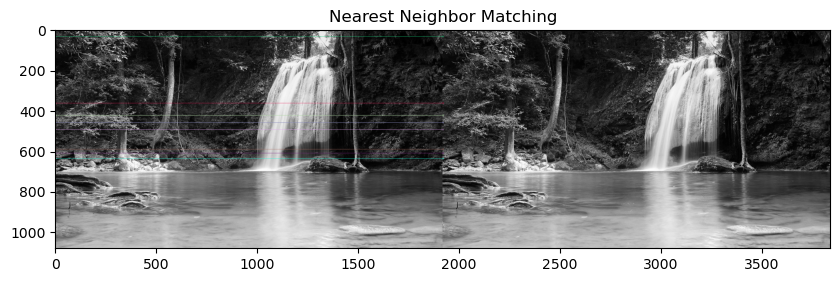

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def nearest_neighbor_matching(img1_path, img2_path):
    # Read images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Initialize the Brute-Force matcher with default params
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 10 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the matches
    plt.figure(figsize=(10, 10))
    plt.imshow(img_matches)
    plt.title("Nearest Neighbor Matching")
    plt.show()

# Example usage:
nearest_neighbor_matching('My.jpg', 'My.jpg')


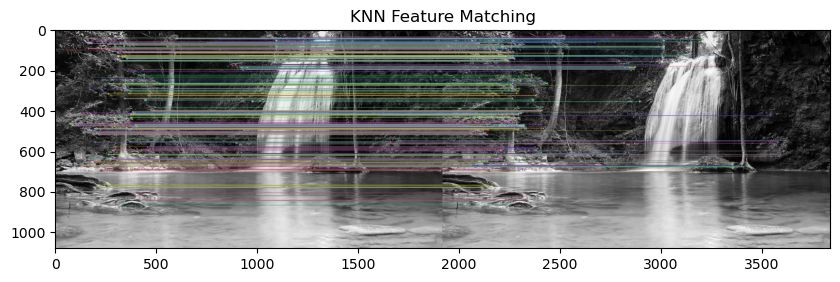

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def knn_feature_matching(img1_path, img2_path, k=2, ratio_thresh=0.75):
    # Read images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect and compute ORB keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Initialize the Brute-Force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # Perform KNN matching
    knn_matches = bf.knnMatch(des1, des2, k=k)

    # Apply ratio test
    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the matches
    plt.figure(figsize=(10, 10))
    plt.imshow(img_matches)
    plt.title("KNN Feature Matching")
    plt.show()

# Example usage:
knn_feature_matching('My.jpg', 'My.jpg')


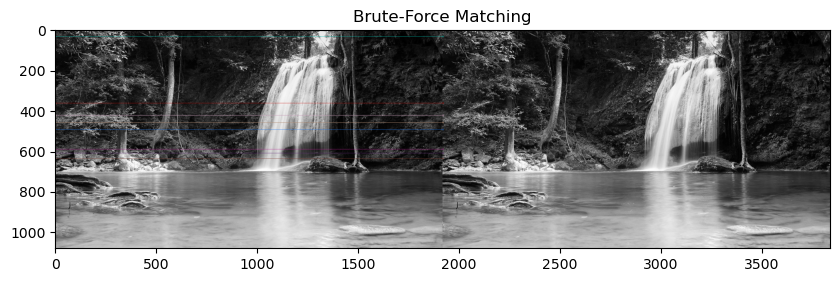

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def brute_force_matching(img1_path, img2_path):
    # Read images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Initialize the Brute-Force matcher with default params
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 10 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the matches
    plt.figure(figsize=(10, 10))
    plt.imshow(img_matches)
    plt.title("Brute-Force Matching")
    plt.show()

# Example usage:
brute_force_matching('My.jpg', 'My.jpg')
